# Determinants of Road Traffic Accident Severity in the UK from 2019 to 2024

In [1]:
import time
start_time = time.time()

## Preparation

- [https://github.com/ucfnxh0/dataScience.git](google.com) 

- Number of words: 1482

- Runtime:16 min 48 sec (*(Memory 7.7 GB, CPU x86_64*)

- Coding environment: SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **shap**: Used for model explainability with SHAP values and visualisations.
    - **xgboost**: Applied as a gradient-boosted decision tree classifier to improve prediction accuracy.
    - **imblearn**: Used for handling class imbalance via SMOTE (Synthetic Minority Oversampling Technique).
    - **re**: Used for feature name processing and regex-based formatting (standard library, but explicitly applied for variable naming logic).
    - **optuna**: for automated hyperparameter optimization in machine learning.

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
import requests, zipfile, io
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
import shap
import re
import optuna
from sklearn.model_selection import cross_val_score

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Globally, road traffic crashes remain the leading cause of human injury and death, with urban areas facing increasing challenges in managing crash severity due to high vehicle densities, a mix of road users, and variable environments (World Health Organisation, 2018). In the UK, where over 100,000 road traffic accidents are reported annually, understanding the causal factors of accident severity is essential for the development of evidence-based traffic safety policies (DfT, 2022).
Previous studies have examined the relationship between environmental factors and road accidents, Christie et al. (2010) examined the effect of mobile speed cameras on accident rates.Ali, Ahmed and Yang (2021) explored the relationship between weather and risky driving styles.Abdel-Aty and Radwan (2000) addressed a variety of factors including demographic characteristics, annual average daily traffic, and horizontal curvature modelling to explore their importance on accident frequency. This project builds on these foundations by analysing UK road accident data from 2019 to 2024. Through the use of statistical filtering, clustering and XGBoost modelling, it aims to identify key risk factors associated with accident severity and provide interpretable insights to inform urban safety strategies.

## Research questions

[[ go back to the top ]](#Table-of-contents)

What factors will have the strongest impact on the severity of road traffic crashes in the UK from 2019 to 2024, and how can predictive modelling help identify high-risk situations?

## Data

[[ go back to the top ]](#Table-of-contents)

This study utilised Road Safety Data from data.gov.uk, a comprehensive dataset recording all road traffic accident reports in the UK. Data from 2019-2024 was selected from which there is a sufficient amount of data and more recent records to more accurately reflect the current traffic environment and risk patterns.
Based on the correlations we matched three tables for accidents, vehicles and casualty, from which a refined subset of variables was selected for analysis, regrouped and recoded. This is shown in the five tables below.

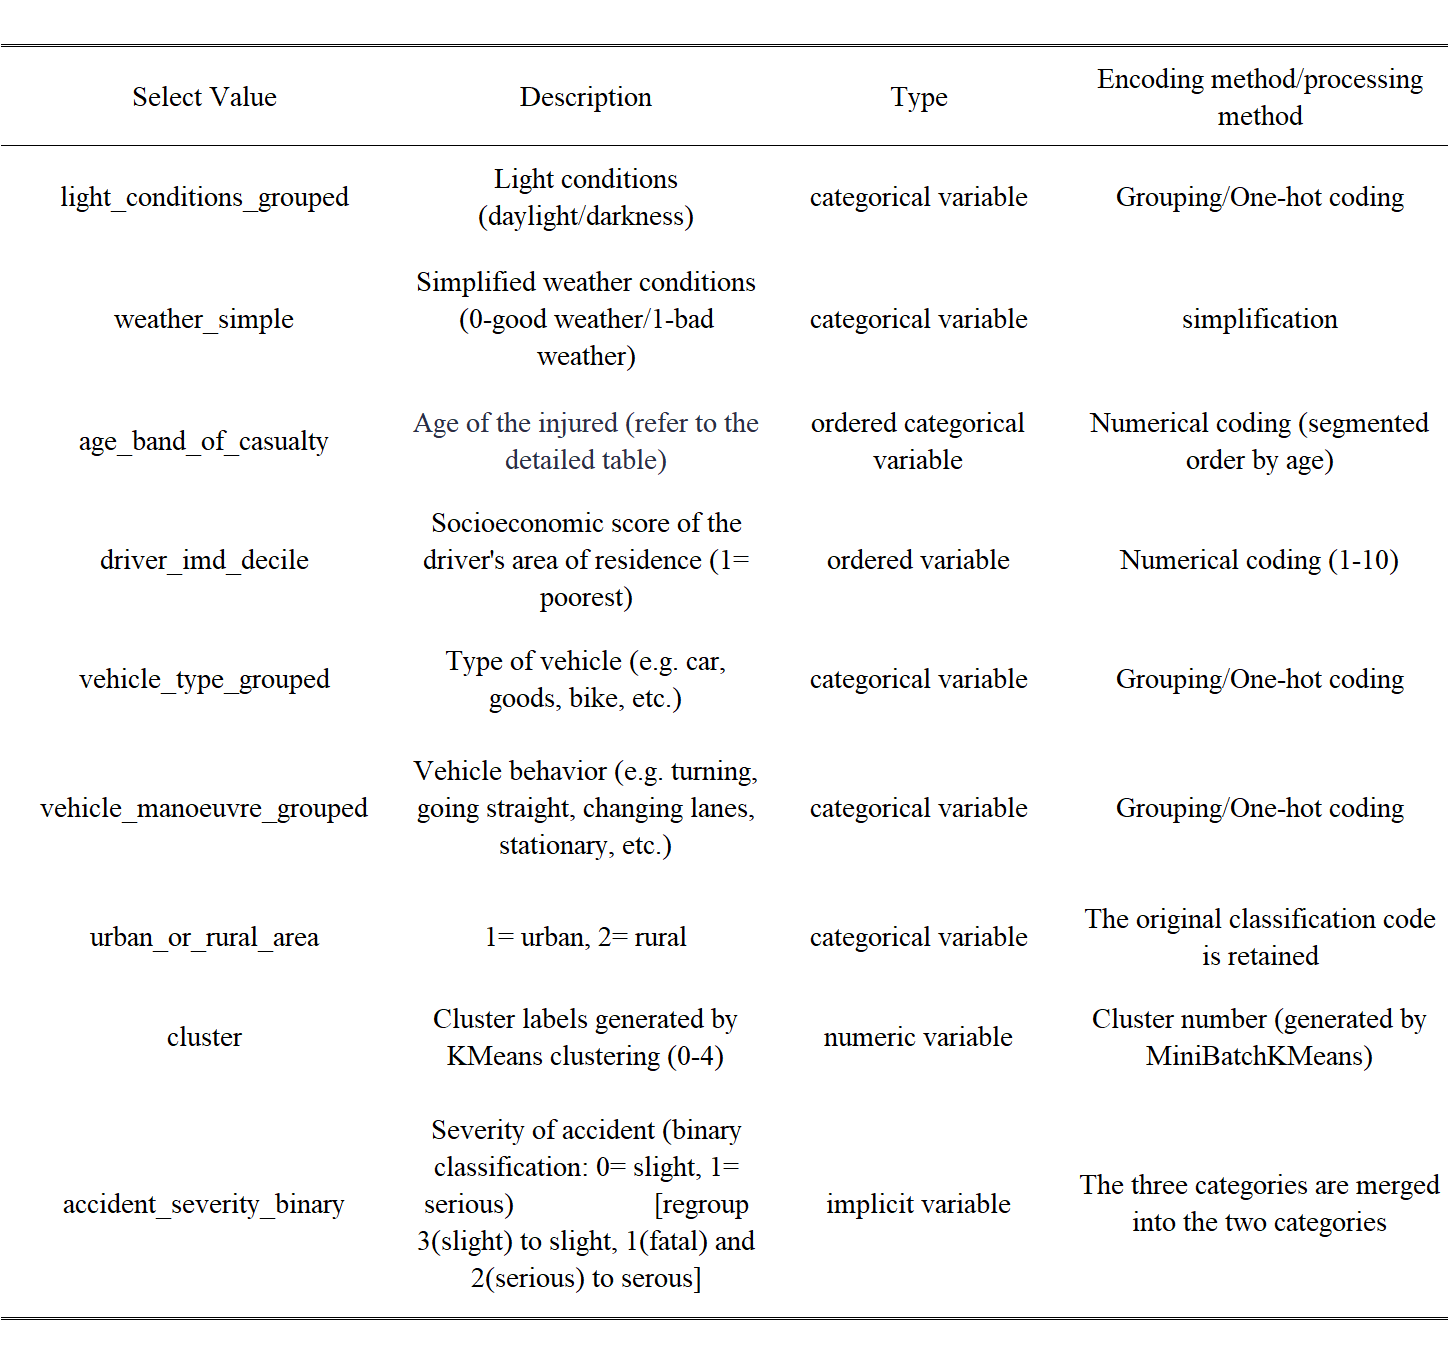

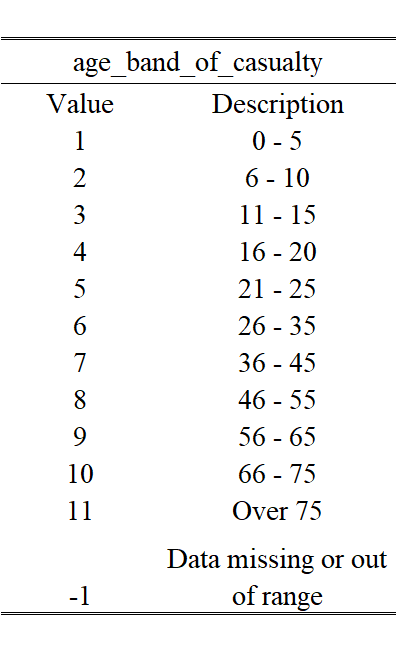

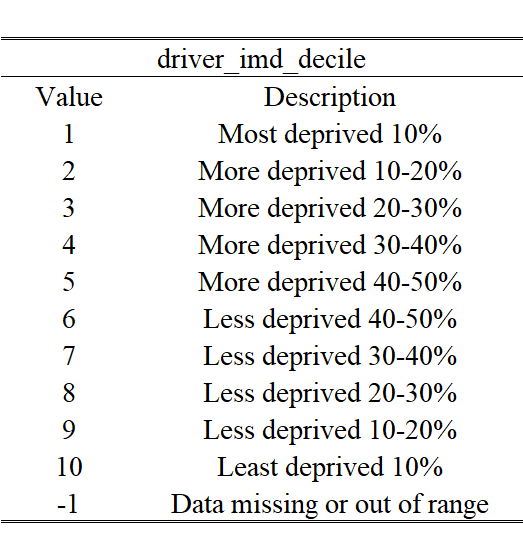

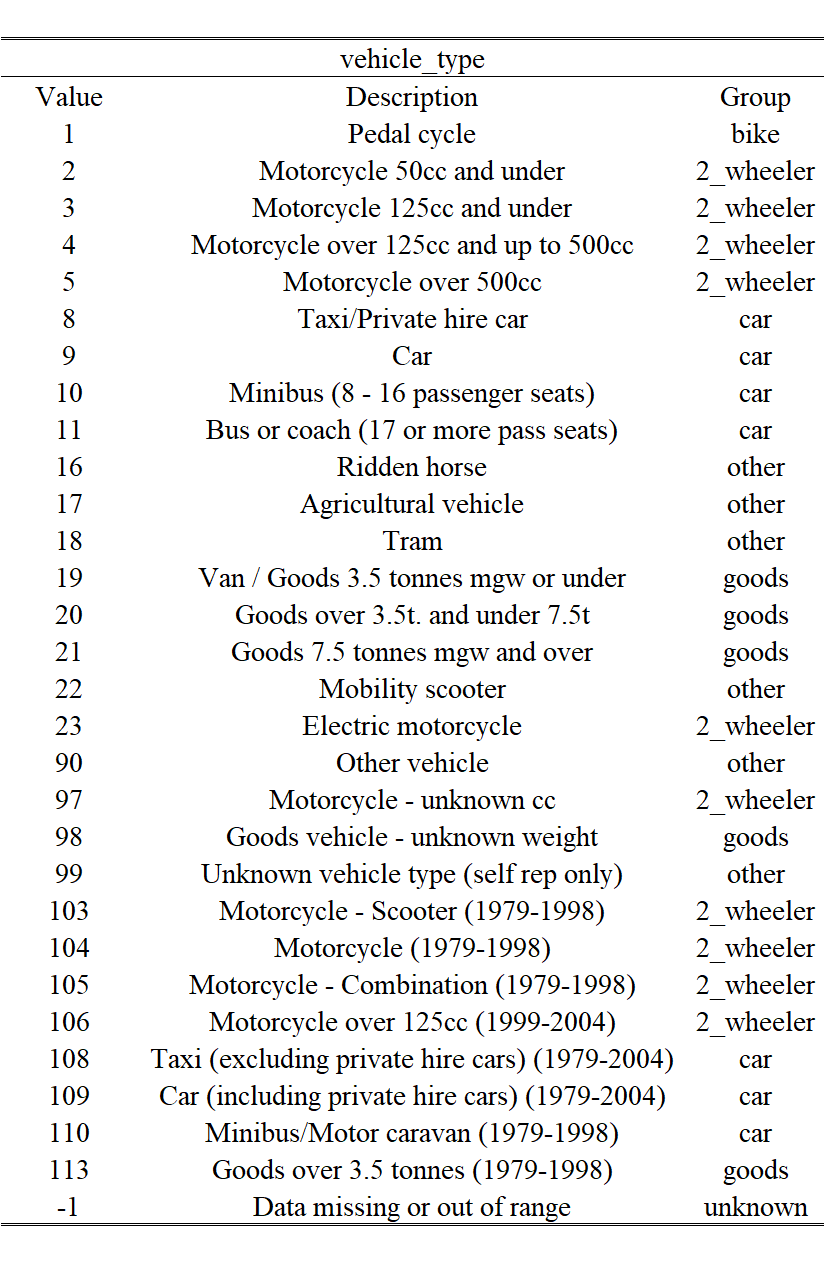

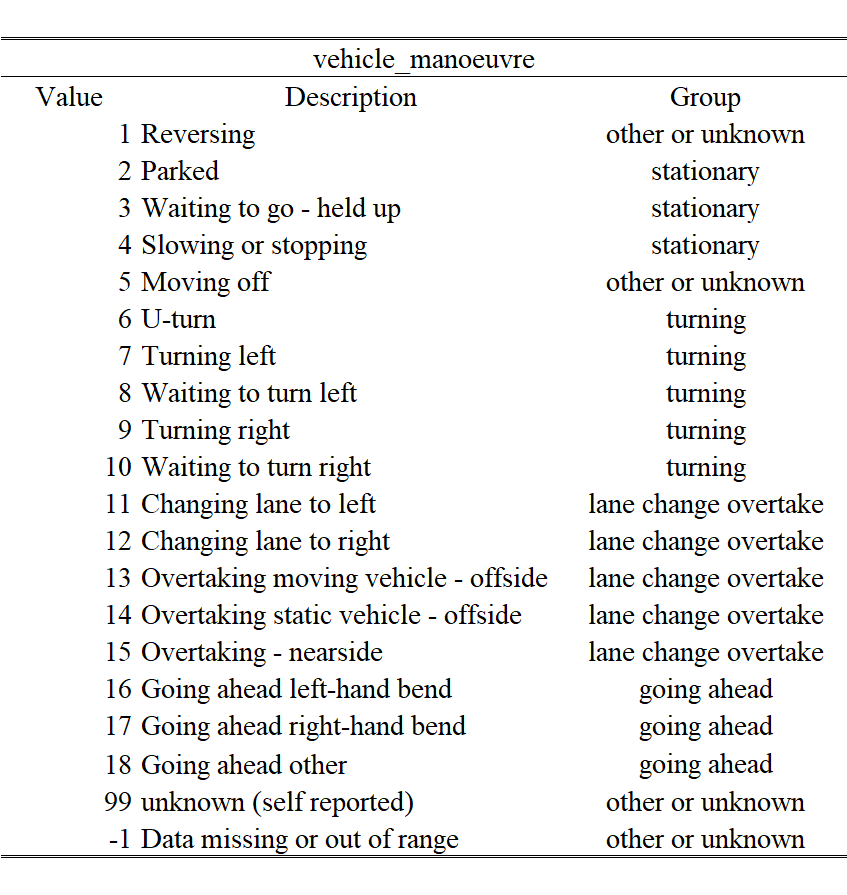

In [3]:
url = "https://github.com/ucfnxh0/dataScience/raw/main/london.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("temp_london") 

shapefile_path = "temp_london/london/London_Borough_Excluding_MHW.shp"
London = gpd.read_file(shapefile_path)

In [4]:
# Import casualty data from 2019-2024, partial columns are converted to strings to prevent mixed type errors
url = "https://github.com/ucfnxh0/dataScience/raw/main/data_final.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:

    dtype_fix = {0: str, 2: str}

    casualty2019 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-2019.csv"), dtype=dtype_fix)
    casualty2020 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-2020.csv"), dtype=dtype_fix)
    casualty2021 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-2021.csv"), dtype=dtype_fix)
    casualty2022 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-2022.csv"), dtype=dtype_fix)
    casualty2023 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-2023.csv"), dtype=dtype_fix)
    casualty2024 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-casualty-provisional-mid-year-unvalidated-2024.csv"), dtype=dtype_fix)

In [5]:
# Import collision data from 2019-2024
with zipfile.ZipFile(io.BytesIO(response.content)) as z:

    dtype_fix = {0: str, 2: str, 35: str}
    dtype_fix1 = {1: str, 3: str}

    collision2019 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-2019.csv"), dtype=dtype_fix)
    collision2020 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-2020.csv"), dtype=dtype_fix)
    collision2021 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-2021.csv"), dtype=dtype_fix)
    collision2022 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-2022.csv"), dtype=dtype_fix)
    collision2023 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-2023.csv"), dtype=dtype_fix)
    collision2024 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024.csv"), dtype=dtype_fix1)

In [6]:
# Import vehicle data from 2019-2024
dtype_fix = {0: str, 2: str}
dtype_fix1 = {1: str, 3: str}
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    viechle2019 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-2019.csv"), dtype=dtype_fix)
    viechle2020 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-2020.csv"), dtype=dtype_fix)
    viechle2021 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-2021.csv"), dtype=dtype_fix)
    viechle2022 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-2022.csv"), dtype=dtype_fix)
    viechle2023 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-2023.csv"), dtype=dtype_fix)
    viechle2024 = pd.read_csv(z.open("data_final/dft-road-casualty-statistics-vehicle-provisional-mid-year-unvalidated-2024.csv"), dtype=dtype_fix1)

In [7]:
#combine single year to 2019-2024
casualty_list=[casualty2019, casualty2020,casualty2021,casualty2022,casualty2023,casualty2024]
casualty_19_24 = pd.concat(casualty_list, ignore_index=True)
collision_list=[collision2019,collision2020,collision2021,collision2022,collision2023,collision2024]
collision_19_24 = pd.concat(collision_list, ignore_index=True)
viechle_list=[viechle2019,viechle2020,viechle2021,viechle2022,viechle2023,viechle2024]
viechle_19_24 = pd.concat(viechle_list, ignore_index=True)

In [8]:
# clean useless columns
collision_19_24.drop(columns=['status',
                              'collision_index',	
                              'collision_year',	
                              'collision_reference',
                              'legacy_collision_severity',	
                              'did_police_officer_attend_scene_of_collision',	
                              'lsoa_of_collision_location'], inplace=True)

In [9]:
# data clean, drop NA
collision6= collision_19_24.dropna()

In [10]:
# Convert the latitude and longitude of collision6 into geometric columns of point types and draw scatter plots
collision6_gdf = gpd.GeoDataFrame(
    collision6,
    geometry=gpd.points_from_xy(collision6['longitude'], collision6['latitude']),
    crs="EPSG:4326" 
)
London = London.to_crs(epsg=4326)
collision6 = collision6_gdf[collision6_gdf.within(London.geometry.union_all())]
collision6 = collision6.to_crs(London.crs)

In [11]:
# A data preprocessing function that selects the specified column from the original DataFrame to remove missing values
def preprocess_table(df, cols, id_cols):
    df_sub = df[cols].dropna().copy()
    for col in df_sub.columns:
        if col not in id_cols and df_sub[col].dtype == 'object':
            df_sub[col] = LabelEncoder().fit_transform(df_sub[col])
    return df_sub

In [12]:
# Preliminary variables were selected based on relevance and completeness
casualty_clean = preprocess_table(
    casualty_19_24,
    ['accident_index', 'vehicle_reference', 'age_band_of_casualty'],
    ['accident_index', 'vehicle_reference']
)

collision_clean = preprocess_table(
    collision_19_24,
    ['accident_index', 'weather_conditions', 'urban_or_rural_area',
     'light_conditions', 'accident_severity'],
    ['accident_index']
     )

viechle_clean = preprocess_table(
    viechle_19_24,
    ['accident_index', 'vehicle_reference', 'vehicle_type', 'vehicle_manoeuvre', 'driver_imd_decile'],
    ['accident_index', 'vehicle_reference']
)

In [13]:
# Merged into the final table, divided into cells to facilitate debugging
cas_viechle = casualty_clean.merge(viechle_clean, on=['accident_index', 'vehicle_reference'], how='inner')
merged_all = cas_viechle.merge(collision_clean, on='accident_index', how='inner')

In [14]:
# Merge too detailed category: vehicle type
vehicle_type_map_5 = {
    1: 'bike',
    2: '2_wheeler',
    3: '2_wheeler',
    4: '2_wheeler',
    5: '2_wheeler',
    8: 'car',
    9: 'car',
    10: 'car',
    11: 'car',
    16: 'other',
    17: 'other',
    18: 'other',
    19: 'goods',
    20: 'goods',
    21: 'goods',
    22: 'other',
    23: '2_wheeler',
    90: 'other',
    97: '2_wheeler',
    98: 'goods',
    99: 'other',
    103: '2_wheeler',
    104: '2_wheeler',
    105: '2_wheeler',
    106: '2_wheeler',
    108: 'car',
    109: 'car',
    110: 'car',
    113: 'goods',
    -1: 'unknown'
}

merged_all['vehicle_type_grouped'] = merged_all['vehicle_type'].map(vehicle_type_map_5)

In [15]:
# Merge too detailed category: vehicle_manoeuvre
vehicle_manoeuvre_map_5 = {
    1: 'other_or_unknown',
    2: 'stationary',
    3: 'stationary',
    4: 'stationary',
    5: 'other_or_unknown',
    6: 'turning',
    7: 'turning',
    8: 'turning',
    9: 'turning',
    10: 'turning',
    11: 'lane_change_overtake',
    12: 'lane_change_overtake',
    13: 'lane_change_overtake',
    14: 'lane_change_overtake',
    15: 'lane_change_overtake',
    16: 'going_ahead',
    17: 'going_ahead',
    18: 'going_ahead',
    99: 'other_or_unknown',
    -1: 'other_or_unknown'
}
merged_all['vehicle_manoeuvre_grouped'] = merged_all['vehicle_manoeuvre'].map(vehicle_manoeuvre_map_5)

In [16]:
# simplify weather condition
def simplify_weather(code):
    if code in [1, 4]:
        return 0  
    elif code in [2, 3, 5, 6, 7]:
        return 1  
    else:
        return 2  

merged_all['weather_simple'] = merged_all['weather_conditions'].apply(simplify_weather)

In [17]:
# merge light condition
light_conditions_map_binary = {
    1: 'daylight',
    4: 'darkness',
    5: 'darkness',
    6: 'darkness',
    7: 'darkness',
    -1: 'unknown'
}
merged_all['light_conditions_grouped'] = merged_all['light_conditions'].map(light_conditions_map_binary)

In [18]:
# For the regrouped data, the parts marked as missing in the original data were removed
merged_all = merged_all[merged_all['weather_simple'] != 2]
merged_all = merged_all[merged_all['light_conditions_grouped'] != 'unknown']
merged_all = merged_all[merged_all['vehicle_type_grouped'] != 'unknown']
merged_all = merged_all[merged_all['vehicle_manoeuvre_grouped'] != 'other_or_unknown']

In [19]:
columns_to_drop = ['vehicle_reference', 'vehicle_type', 'vehicle_manoeuvre', 'weather_conditions', 'light_conditions']
merged_all = merged_all.drop(columns=columns_to_drop)

In [20]:
# For data that do not need to be regrouped
merged_all = merged_all[merged_all['age_band_of_casualty'] != -1]
merged_all = merged_all[merged_all['driver_imd_decile'] != -1]
merged_all = merged_all[merged_all['urban_or_rural_area'] != -1]
merged_all = merged_all[merged_all['urban_or_rural_area'] != 3]
merged_all = merged_all[merged_all['accident_severity'] != -1]

In [21]:
# one-hot encode
one_hot_vars = [
    'vehicle_type_grouped',
    'vehicle_manoeuvre_grouped',
    'light_conditions_grouped'
]

dummies = pd.get_dummies(merged_all[one_hot_vars], prefix=one_hot_vars)

merged_all = pd.concat([merged_all, dummies], axis=1)

In [22]:
# The data were further streamlined in preparation for modeling
merge_encoded = merged_all.select_dtypes(exclude='object')

## Methodology

[[ go back to the top ]](#Table-of-contents)

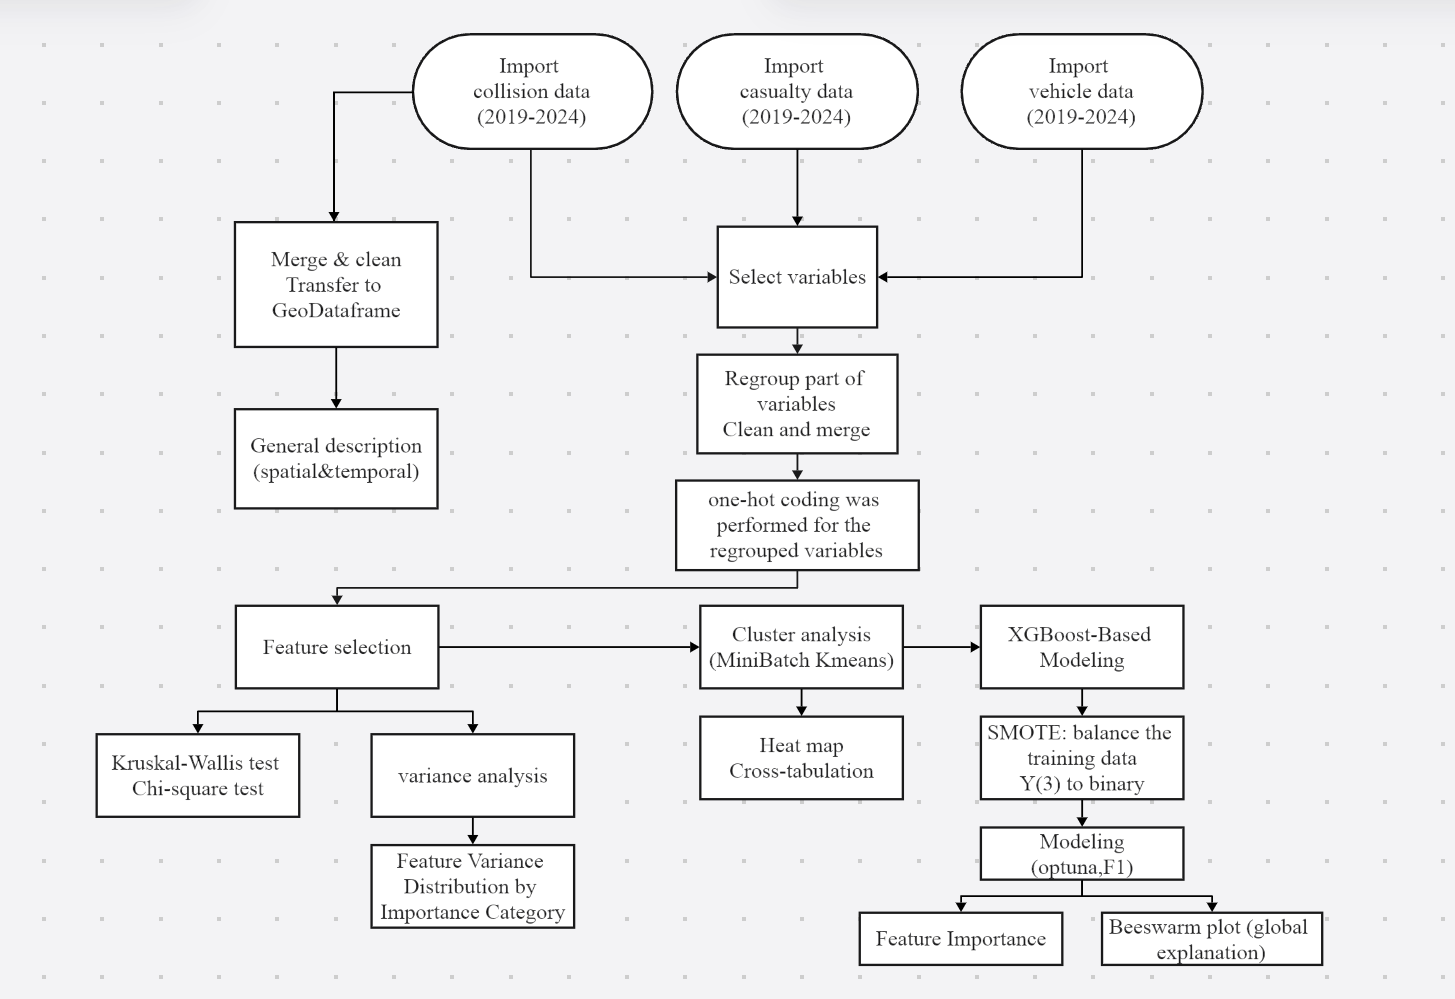

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

### Spatial and temporal overview of accidents
Firstly, I selected accident data for the London region to provide an initial visualisation of the data through temporal and spatial distribution. Data for the year 2024 was excluded from this section due to the absence of latitude and longitude data for that year. The map below shows the geographic location of all road accidents of varying severity that occurred in London between 2019 and 2023. The bar charts show the change in the number and percentage of accidents of different severities for each year.
There is a clear concentration of accidents in central London and along the main arterial roads, particularly in inner cities such as Westminster, Camden and Lambeth. The concentration of high severity accidents in high traffic areas suggests that the severity of accidents may be related to traffic flow, road layout or urban infrastructure.The total number of accidents declined slightly in 2020, which may have been affected by the epidemic-related impacts, but stabilised in the following years. Slight injuries consistently account for the largest proportion of accidents, while fatal accidents are relatively rare. Nevertheless, the proportion of serious and fatal accidents appears to be relatively stable, highlighting the continued need to analyse the factors contributing to severity.

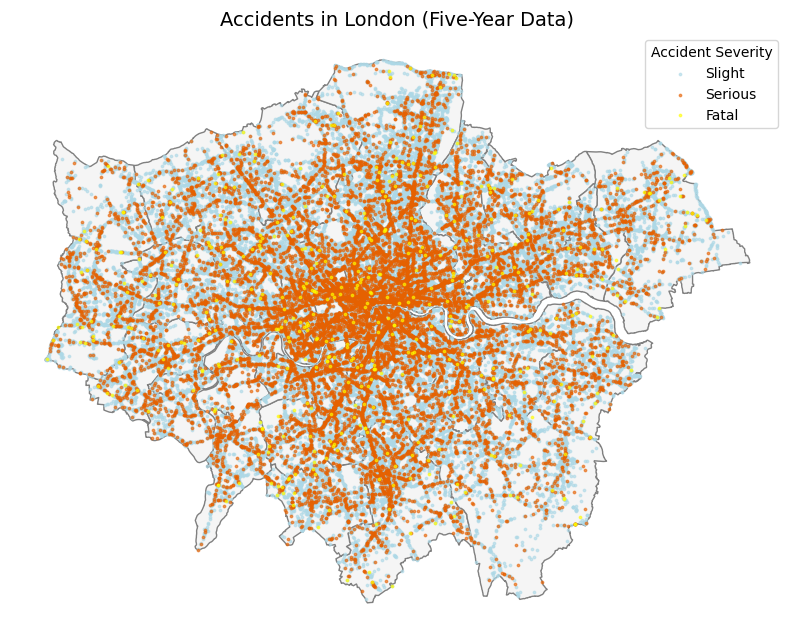

In [23]:
# scatter plots,Spatial distribution
severity_map = {1.0: 'Fatal', 2.0: 'Serious', 3.0: 'Slight'}
collision6['severity_label'] = collision6['accident_severity'].map(severity_map)

fig, ax = plt.subplots(figsize=(10, 10))
London.plot(ax=ax, color='#F5F5F5', edgecolor='gray')

severity_colors = {
    'Slight': '#ADD8E6',
    'Serious': '#e66101',
    'Fatal': '#FFFD00'
}

for severity, color in severity_colors.items():
    subset = collision6[collision6['severity_label'] == severity]
    if not subset.empty:
        gpd.GeoDataFrame(subset, geometry='geometry', crs=collision6.crs).plot(
            ax=ax,
            marker='o',
            color=color,
            markersize=3,
            alpha=0.6,
            label=severity
        )

plt.legend(title='Accident Severity')
plt.title("Accidents in London (Five-Year Data)", fontsize=14)
plt.axis('off')
plt.show()


In [24]:
severity_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
collision6 = collision6_gdf[collision6_gdf.within(London.geometry.union_all())].copy()
collision6['accident_severity'] = collision6['accident_severity'].map(severity_mapping)
severity_counts = collision6.groupby(['accident_year', 'accident_severity']).size().unstack(fill_value=0)
severity_counts = severity_counts.astype(int)

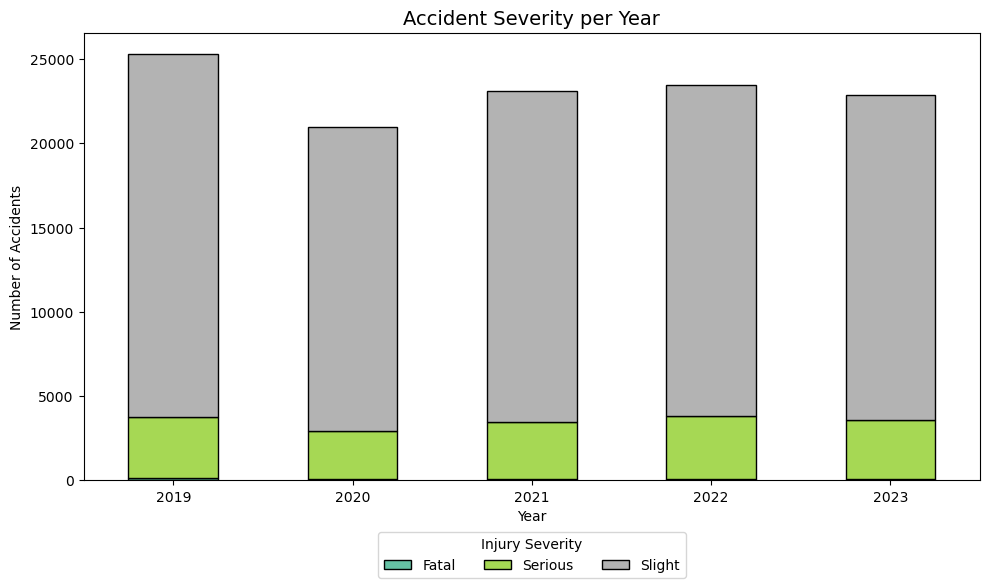

In [25]:
# Draw a stacked bar chart
severity_counts.index = severity_counts.index.astype(int)
severity_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2', edgecolor='black')

plt.title("Accident Severity per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.legend(title='Injury Severity', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Hypothesis testing and analysis of variance
Calculations were made as to which features had a statistically significant relationship with accident severity to screen variables for later modelling. The Kruskal-Wallis test was used for ordered categorical and numerical variables, and the Chi-square test was used for unordered categorical variables. All statistical tests were performed at a 95% confidence level.
As shown in the results table, all three ordered variables (urban_or_rural_area, age_band_of_casualty, and driver_imd_decile) showed very low p-values (p<0.001), indicating strong statistical significance. Similarly, Chi-square test showed that all four categorical factors were significantly correlated with accident severity, and all p values are less than 0.01.These results validate the correctness of the feature selection and the significant association of these features with accident severity.

In [26]:
# P-values were calculated for the selected variables
# the first part of the Kruskal-Wallis test was for the ordered variables
def kruskal_pvalues(merged_all, target_col, variable_list, alpha=0.05):
    results = []

    for var in variable_list:
        try:
            
            groups = [merged_all[merged_all[target_col] == cat][var].dropna() for cat in merged_all[target_col].unique()]
            
            if len(groups) < 2 or any(len(g) == 0 for g in groups):
                p_val = None
            else:
                p_val = kruskal(*groups).pvalue

            results.append({
                'Variable': var,
                'P-Value': p_val,
                'Significant': p_val is not None and p_val < alpha
            })

        except Exception as e:
            results.append({'Variable': var, 'P-Value': None, 'Error': str(e), 'Significant': False})

    return pd.DataFrame(results).sort_values(by='P-Value')

In [27]:
target = 'accident_severity'
variables = ['age_band_of_casualty', 'driver_imd_decile','urban_or_rural_area']

results = kruskal_pvalues(merged_all, target, variables)
print(results)

               Variable        P-Value  Significant
2   urban_or_rural_area   0.000000e+00         True
0  age_band_of_casualty  2.063149e-276         True
1     driver_imd_decile   3.337652e-52         True


In [28]:
# Chi-square test for unordered variables
def chi2_pvalues(merged_all, target_col, variable_list, alpha=0.05):
    results = []

    for var in variable_list:
        try:
           
            contingency = pd.crosstab(merged_all[var], merged_all[target_col])
           
            if contingency.shape[0] < 2 or contingency.shape[1] < 2:
                p_val = None
            else:
                p_val = chi2_contingency(contingency)[1]

            results.append({
                'Variable': var,
                'P-Value': p_val,
                'Significant': p_val is not None and p_val < alpha
            })

        except Exception as e:
            results.append({'Variable': var, 'P-Value': None, 'Error': str(e), 'Significant': False})

    return pd.DataFrame(results).sort_values('P-Value')
    
categorical_vars = [
    'vehicle_type_grouped',
    'weather_simple',
    'vehicle_manoeuvre_grouped',
    'light_conditions_grouped'
]

chi2_results = chi2_pvalues(merged_all, 'accident_severity', categorical_vars)

print(chi2_results)

                    Variable       P-Value  Significant
0       vehicle_type_grouped  0.000000e+00         True
2  vehicle_manoeuvre_grouped  0.000000e+00         True
3   light_conditions_grouped  0.000000e+00         True
1             weather_simple  7.713348e-08         True


To refine the set of modelling variables, we used the variance thresholding method to further filter from the 15 candidate features. Two variables, age_band_of_casualty (variance = 5.00) and driver_imd_decile (variance = 7.94), had significantly higher variability and were therefore categorised as core features, suggesting that they have strong discriminatory power between different accident severities. Three variables had lower variance and poorer discriminatory power. However, we purposely retained these variables with lower variance for further analyses. This decision was based on their theoretical relevance as well as the strong statistical significance they showed in earlier hypothesis tests. These features represent different behavioural or contextual information in accident scenarios and are highly interpretable. And as rare scenarios may be associated with severe accidents, they were retained.

In [29]:
# variance analysis
def variance_filter(merge_encoded, threshold=0.05):
    
    target_cols = ['accident_severity']
    
    candidate_vars = [col for col in merge_encoded.columns if col not in target_cols]
    
    X = merge_encoded[candidate_vars].copy()
    X = X.astype(float)
    
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    
    support_mask = selector.get_support()
    selected_vars = X.columns[support_mask].tolist()
    variances = pd.Series(selector.variances_, index=X.columns)
    
    removed_vars = list(set(X.columns) - set(selected_vars))
    
    print(f"Total number of variables：{len(X.columns)}")
    print(f"Number of retained variables：{len(selected_vars)}")
    print(f"Number of excluded variables：{len(removed_vars)} (variances < {threshold})")
    
    return selected_vars, variances, removed_vars

selected_vars, variances, removed_vars = variance_filter(merge_encoded, threshold=0.05)

print(" Variance (all variables):")
print(variances.sort_values())

print("\n excluded variables:")
print(variances[removed_vars].sort_values())

Total number of variables：15
Number of retained variables：13
Number of excluded variables：2 (variances < 0.05)
 Variance (all variables):
vehicle_type_grouped_other                        0.012869
vehicle_type_grouped_goods                        0.045059
vehicle_manoeuvre_grouped_lane_change_overtake    0.050953
vehicle_type_grouped_bike                         0.103499
vehicle_type_grouped_2_wheeler                    0.108013
vehicle_manoeuvre_grouped_turning                 0.110389
vehicle_manoeuvre_grouped_stationary              0.117369
weather_simple                                    0.127223
light_conditions_grouped_darkness                 0.204523
light_conditions_grouped_daylight                 0.204523
vehicle_type_grouped_car                          0.210307
vehicle_manoeuvre_grouped_going_ahead             0.216152
urban_or_rural_area                               0.241118
age_band_of_casualty                              5.008873
driver_imd_decile                   

In [30]:
# Feature importance grouping and screening
def assign_importance_group(var_dict):
    result = []
    for var, var_val in var_dict.items():
        if var_val <= 0.05:
            tag = 'sparse'
        elif var_val <= 0.2:
            tag = 'supporting'
        else:
            tag = 'core'
        result.append((var, var_val, tag))
    return pd.DataFrame(result, columns=['Variable', 'Variance', 'Importance_Group'])

importance_df = assign_importance_group(variances)
importance_df = importance_df.sort_values(by='Variance', ascending=False).reset_index(drop=True)

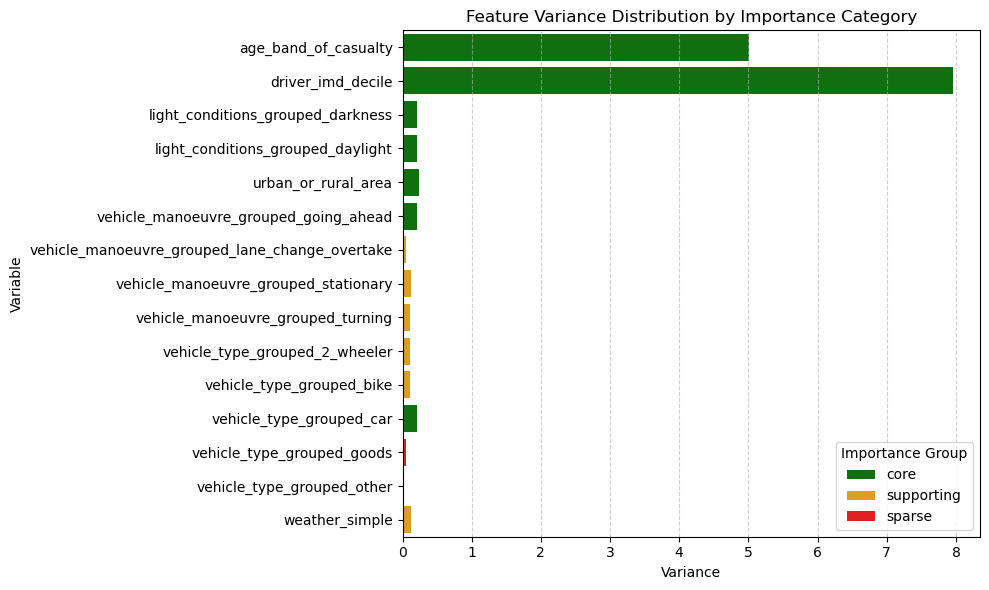

In [31]:
# bar chart: Feature Variance Grouped by Variable Type
def extract_variable_group(name):
    match = re.match(r'^([a-z_]+?_grouped)', name)
    return match.group(1) if match else name

importance_df['Group'] = importance_df['Variable'].apply(extract_variable_group)
importance_df_sorted = importance_df.sort_values(by=['Group', 'Variable']).reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df_sorted,
    x='Variance',
    y='Variable',
    hue='Importance_Group',
    dodge=False,
    palette={'core': 'green', 'supporting': 'orange', 'sparse': 'red'}
)
plt.title('Feature Variance Distribution by Importance Category')
plt.xlabel('Variance')
plt.ylabel('Variable')
plt.legend(title='Importance Group')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Cluster analysis
The internal structure of the data was further explored through MiniBatch KMeans clustering to see the combination of features for different types of accidents. The heat map shows the average value of each feature in each cluster, demonstrating the characteristics of a specific type of accident. 
Cluster 0 represents moderate-income, middle-aged drivers, often navigating turning situations during the day — potentially at junctions or intersections. This cluster has a relatively low proportion of serious accidents, possibly due to cautious driving behaviors in complex road environments.
Cluster 1 is predominantly associated with accidents in the dark. Despite the risk factors, the severity rate is comparatively lower, which might reflect reduced traffic volume at night or more cautious nighttime behavior.
Cluster 2 paints a picture of urban straight-driving incidents, such as daily commutes. Notably, Cluster 2 has the highest rate of serious accidents, implying that young, moderately deprived urban drivers may be more exposed to high-severity accidents, potentially due to time pressure, distraction, or lower risk awareness during routine travel.
Cluster 3 happen in high-visibility conditions and intersection or congestion scenarios.Cluster 4 is similar in profile to Cluster 3.

In [32]:
# cluster
columns_to_exclude = [
    'cluster',                   
    'accident_severity',            
]

X = merge_encoded.drop(columns=columns_to_exclude,errors='ignore')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10000, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

merge_encoded['cluster'] = clusters

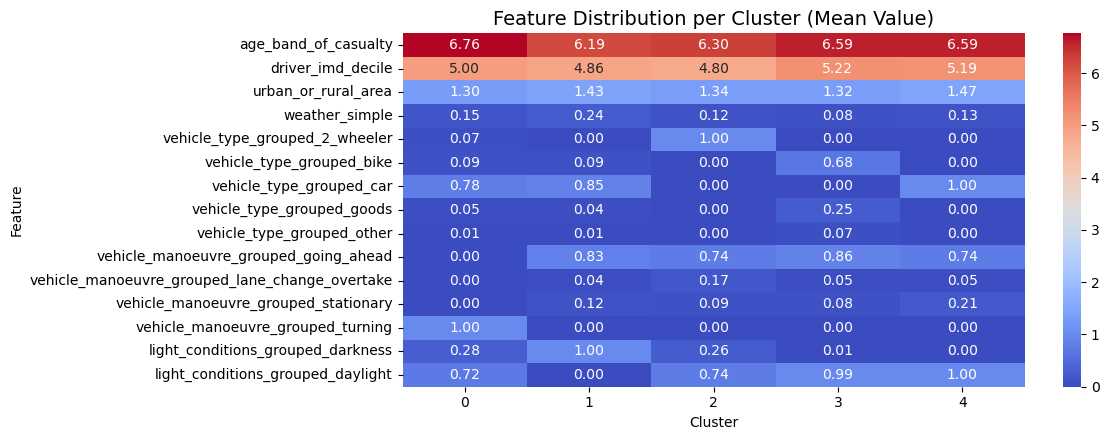

In [33]:
# The heat map shows the average value of each feature in each cluster 
#(One-Hot feature is "the proportion of occurrences in that class")
df = merge_encoded.copy()

bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

exclude_cols = ['accident_severity']
feature_cols = [col for col in df.columns if col not in exclude_cols and col != 'cluster']

numeric_cols = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()

cluster_summary = df.groupby('cluster')[numeric_cols].mean()

plt.figure(figsize=(12, len(cluster_summary.columns) * 0.3))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Feature Distribution per Cluster (Mean Value)", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [34]:
# Cross-tabulation: Cluster Number vs Serious Incident Rate
cluster_vs_severity = pd.crosstab(
    merge_encoded['cluster'],
    merge_encoded['accident_severity'],
    normalize='index'
)
cluster_vs_severity.columns = ['Fatal', 'Serious', 'Slight']
#cluster_vs_severity.to_csv("cluster_vs_severity_distribution.csv", index=True)


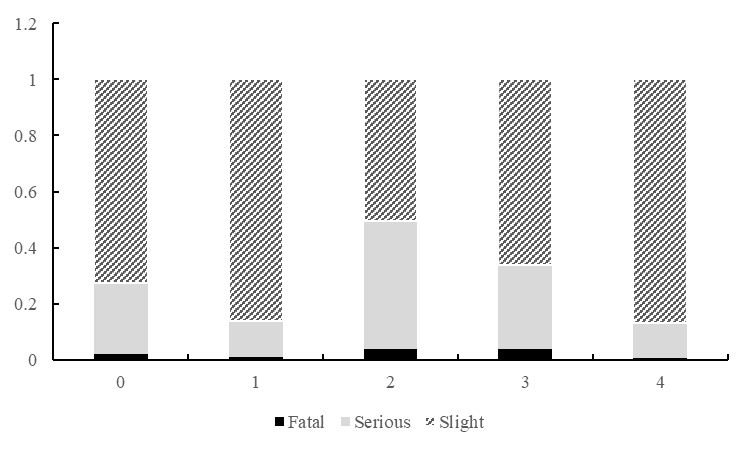

### XGBoost-Based Modeling and Feature Explanation
To address the class imbalance in the original data—where non-serious accidents significantly outnumber serious ones—SMOTE was applied to balance the training set. The XGBoost binary classification model was then trained on this balanced data.
The classification report shows that the model performs well in identifying serious accidents, achieving a recall of 0.77, meaning most actual serious accidents were correctly identified. For the non-serious category, the model achieves a precision of 0.83, suggesting high confidence when it predicts an accident as non-serious. However, the recall for non-serious cases is relatively low at 0.41, indicating many non-serious accidents are misclassified as severe.
The confusion matrix confirms this bias, as a large number of non-serious cases are predicted as serious. Despite this, the model remains practically valuable in the road safety context, where failing to detect serious accidents has more critical consequences than overestimating the severity of minor ones.

In [35]:
#XGBoost：accident_severity
# Original label：1=Fatal, 2=Serious, 3=Slight
# merge：1 or 2 → 1（serious），3 → 0（nonserious）
y_binary = merge_encoded['accident_severity'].map(lambda x: 1 if x in [1, 2] else 0)

X = merge_encoded.drop(columns=['accident_severity', 'cluster'], errors='ignore')

print("Original binary classification distribution:\n", y_binary.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n Distribution of the training set after SMOTE: \n", pd.Series(y_train_smote).value_counts())


Original binary classification distribution:
 accident_severity
0    365489
1    129857
Name: count, dtype: int64

 Distribution of the training set after SMOTE: 
 accident_severity
1    255842
0    255842
Name: count, dtype: int64


In [36]:
# Adjusted 1
xgb_binary = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=146,
    learning_rate=0.1665921013033715,
    max_depth=10,
    subsample=0.9188815449809645,
    colsample_bytree=0.7607645397280131,
    random_state=42
)


xgb_binary.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7607645397280131, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1665921013033715,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
# optuna：Automatic parameter adjustment
def objective(trial):
    model = XGBClassifier(
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        eval_metric='logloss',
        random_state=42
    )
    
    score = cross_val_score(model, X_train_smote, y_train_smote, cv=2, scoring='f1', n_jobs=-1)
    return score.mean()

study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

study.optimize(objective, n_trials=20, timeout=600) 
best_params = study.best_params
print(" Optimal parameter combination:", study.best_params)
print(" Best average F1 score:", study.best_value)

[I 2025-04-21 14:46:10,066] A new study created in memory with name: no-name-763affd4-3077-4c11-b2e9-b95e15ed24d7
[I 2025-04-21 14:46:21,082] Trial 0 finished with value: 0.6190704193653245 and parameters: {'max_depth': 8, 'learning_rate': 0.15227115916197165, 'n_estimators': 104, 'subsample': 0.9771722678011744, 'colsample_bytree': 0.8689029118351542}. Best is trial 0 with value: 0.6190704193653245.
[I 2025-04-21 14:46:33,960] Trial 1 finished with value: 0.618870933542039 and parameters: {'max_depth': 8, 'learning_rate': 0.12452987230660917, 'n_estimators': 143, 'subsample': 0.8716748946823141, 'colsample_bytree': 0.8343361990273905}. Best is trial 0 with value: 0.6190704193653245.
[I 2025-04-21 14:46:51,936] Trial 2 finished with value: 0.6069826104181508 and parameters: {'max_depth': 6, 'learning_rate': 0.021117702365653426, 'n_estimators': 251, 'subsample': 0.6047780664772566, 'colsample_bytree': 0.8310926334549974}. Best is trial 0 with value: 0.6190704193653245.
[I 2025-04-21 14

 Optimal parameter combination: {'max_depth': 10, 'learning_rate': 0.1916179688448471, 'n_estimators': 297, 'subsample': 0.7952218405765391, 'colsample_bytree': 0.9910898158617698}
 Best average F1 score: 0.6252683046417044


In [38]:
# Adjusted 1
xgb_binary = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
     **best_params
)


xgb_binary.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9910898158617698, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1916179688448471,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=297, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
y_prob = xgb_binary.predict_proba(X_test)[:, 1]  

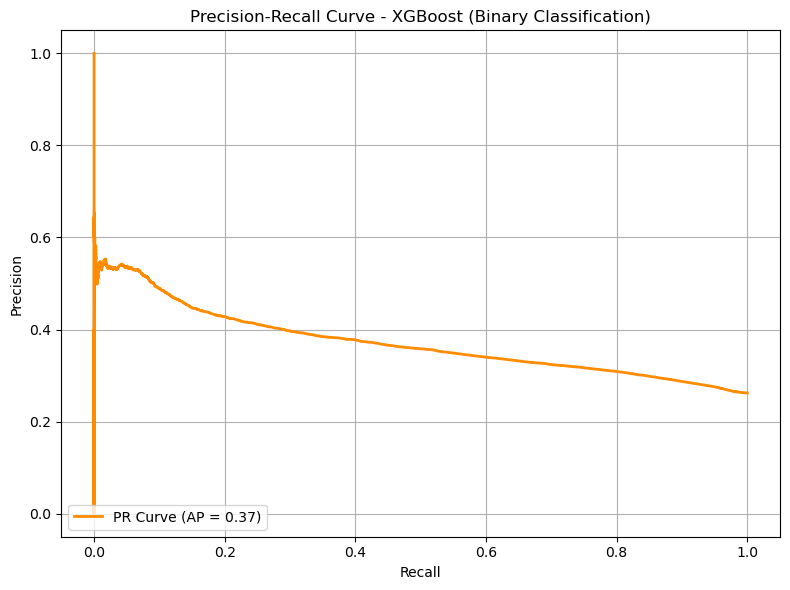

In [40]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost (Binary Classification)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

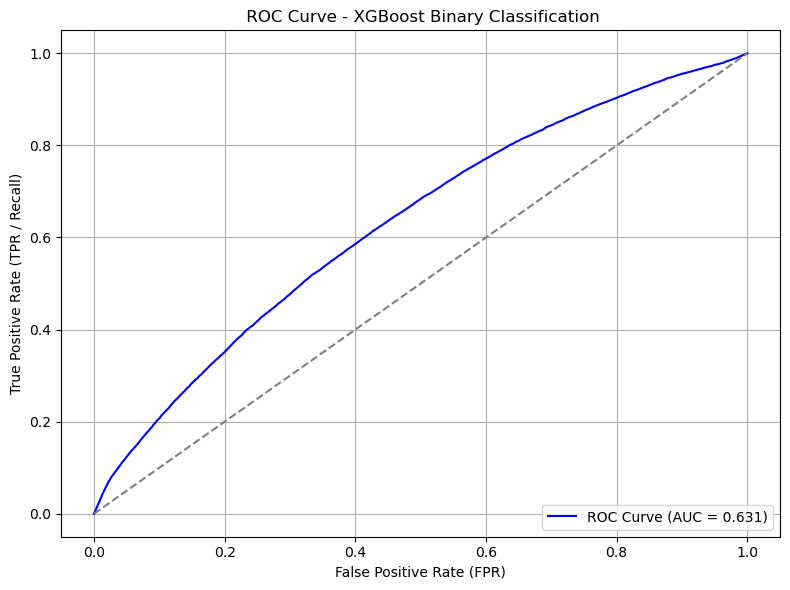

 Best classification threshold (F1 maximum): 0.423
 Corresponding F1 score: 0.446
 AUC: 0.631


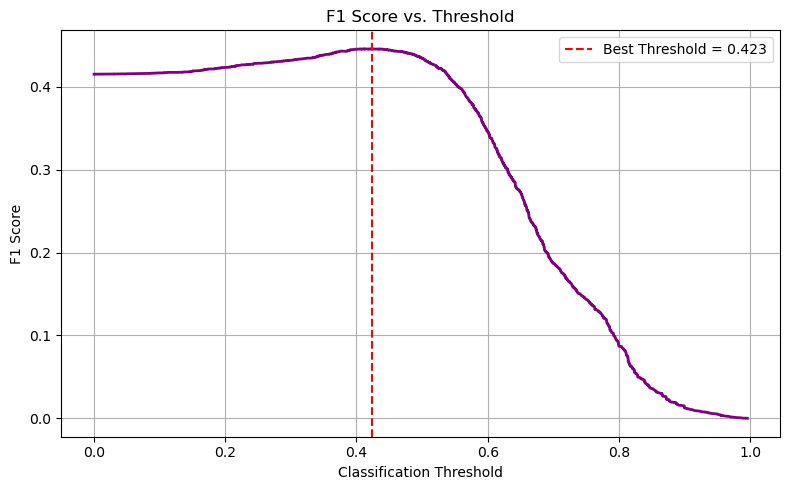

In [41]:
#  ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob) 

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title(" ROC Curve - XGBoost Binary Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#  F1 analysis
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

# Best threshold
print(f" Best classification threshold (F1 maximum): {best_threshold:.3f}")
print(f" Corresponding F1 score: {best_f1:.3f}")
print(f" AUC: {roc_auc:.3f}")  

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], color='purple', lw=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.xlabel("Classification Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 classification report（XGBoost - Binary）：
                precision    recall  f1-score   support

Non-Severe (0)       0.83      0.41      0.55    109647
    Severe (1)       0.31      0.77      0.45     38957

      accuracy                           0.50    148604
     macro avg       0.57      0.59      0.50    148604
  weighted avg       0.70      0.50      0.52    148604



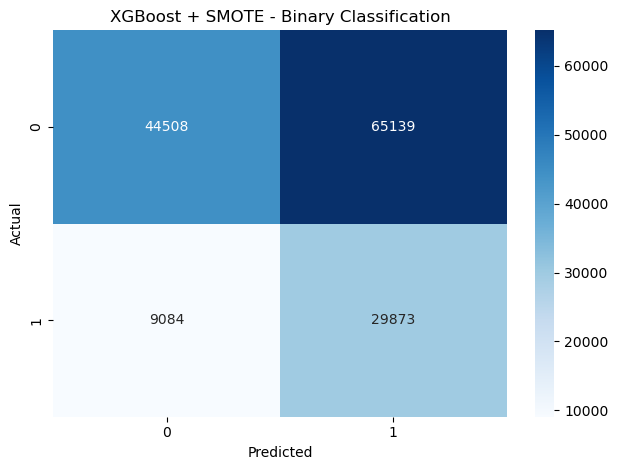

In [42]:
# set best threshold
y_pred = (y_prob > best_threshold).astype(int)


print("\n classification report（XGBoost - Binary）：")
print(classification_report(y_test, y_pred, target_names=['Non-Severe (0)', 'Severe (1)']))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost + SMOTE - Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

The feature importance ranking indicates that vehicle_manoeuvre_grouped_stationary is the most influential factor in predicting accident severity, followed by vehicle_type_grouped_2_wheeler and light_conditions_grouped_daylight. This suggests that the type of vehicle and its state during the accident play a significant role in determining severity.
The SHAP beeswarm plot provides further insight into the directionality of these effects. Specifically, accidents occurring in daylight conditions and involving cars are associated with lower SHAP values, indicating a lower predicted severity. In contrast, nighttime conditions and stationary vehicles push predictions toward the severe class. This aligns with real-world understanding, where visibility and situational awareness are diminished at night or when unexpected obstacles (like stationary vehicles) are present.
Notably, younger casualties are associated with higher SHAP values, suggesting greater risk of severe outcomes, whereas older individuals tend to be linked with less severe predictions. Similarly, lower values of driver_imd_decile, which reflect higher levels of deprivation, are also connected to increased predicted severity, highlighting the intersection of socioeconomic status and road safety risk.
While vehicle_type_grouped_2_wheeler ranks highly in feature importance, its SHAP distribution shows relatively moderate variation, suggesting its impact is more categorical than directional. 

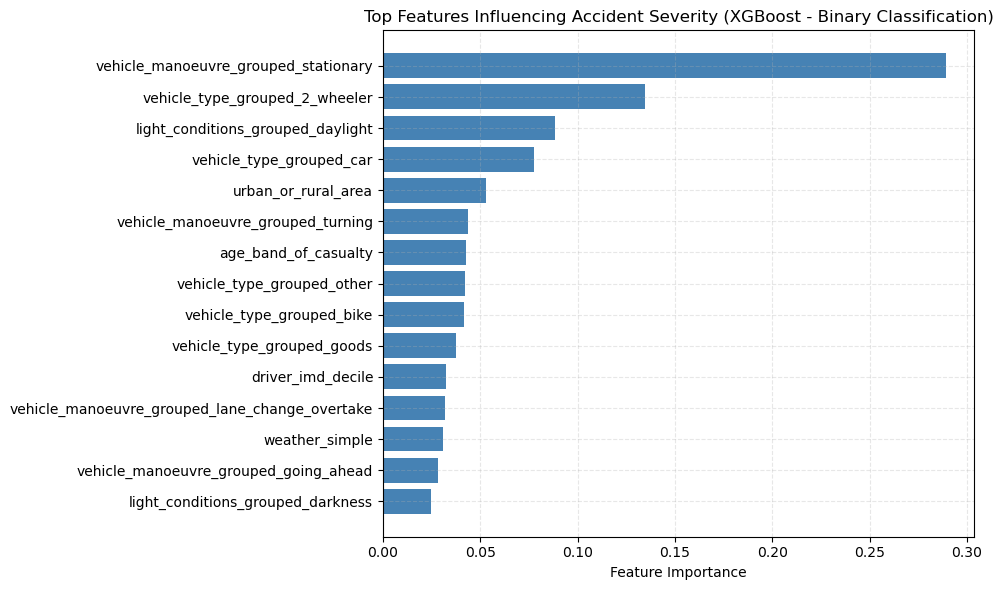

In [43]:
# Feature Importance
feature_names = X.columns.tolist()


importances = xgb_binary.feature_importances_


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1], color='steelblue')
plt.xlabel('Feature Importance')
plt.title('Top Features Influencing Accident Severity (XGBoost - Binary Classification)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

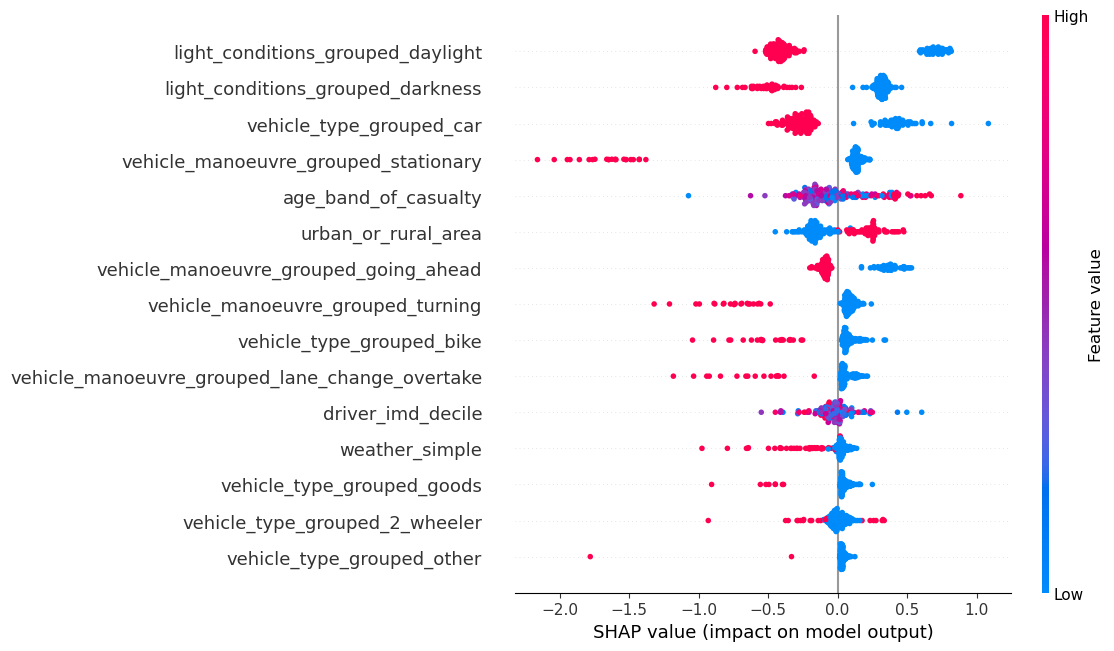

In [44]:
# Beeswarm plot (global explanation): identifying the features with the strongest influence on model predictions
X_test_safe = X_test[:200].copy()
X_test_safe = X_test_safe.astype(float).fillna(0)

explainer = shap.Explainer(xgb_binary)
shap_values = explainer(X_test_safe)
shap.plots.beeswarm(shap_values, max_display=15)



## Conclusion

[[ go back to the top ]](#Table-of-contents)

This study investigated the factors contributing to the severity of road traffic accidents in the UK between 2019 and 2024, based on an integrated dataset combining accident, casualty, and vehicle information. Spatial and temporal analyses revealed that severe accidents were predominantly concentrated in central urban areas, with their proportion remaining relatively stable over time. Statistical tests and variance analysis identified key contributing factors such as age, deprivation, vehicle type, and manoeuvre behaviour.
Cluster analysis uncovered meaningful patterns in accident scenarios—particularly the elevated risk among young drivers during daytime, straight-driving conditions in urban settings. This highlights the need for targeted interventions tailored to specific urban commuting contexts. The XGBoost model, enhanced by SMOTE balancing, achieved reliable predictive performance, especially in identifying severe accidents. Feature importance rankings and SHAP values offered further interpretability.
The models show that stationary vehicles, nighttime conditions, and urban settings were strongly associated with increased severity. In contrast, cars, turning manoeuvres, and daylight significantly contributed to lower severity predictions. While two-wheelers appeared as important in feature ranking, their SHAP impact was relatively modest. These findings point to concrete policy implications, such as enhancing visibility and regulation during nighttime or in high-density areas, and prioritising protections for vulnerable road users. Future work could further enrich these insights by incorporating behavioural data or road infrastructure features to better explain the root causes of severe accidents.

## References

[[ go back to the top ]](#Table-of-contents)

Abdel-Aty, M., A., and Radwan, A., E. (2000). Modeling traf®c accident occurrence and involvement. *Accident Analysis and Prevention*, 32, pp.633-642.

Ali, E., M., Ahmed, M., M., Yang, G., C. (2021). Normal and risky driving patterns identification in clear and rainy weather on freeway segments using vehicle kinematics trajectories and time series cluster analysis. *IATSS Research*, 45(1), pp.137-152.

Christie, S., M. et al. (2003). Are mobile speed cameras effective? A controlled before and after study. *Injury Prevention*, 9(4), pp.302–306.

Department for Transport (2023). *Reported road casualties Great Britain: annual report 2022*. London: Department for Transport. Available at: https://www.gov.uk/government/statistics/reported-road-casualties-great-britain-annual-report-2022 [Accessed 18 Apr. 2025].

World Health Organization (2018). *Global status report on road safety 2018*. Geneva: World Health Organization. Available at: https://www.who.int/publications/i/item/9789241565684 [Accessed 18 Apr. 2025].

In [45]:
end_time = time.time()
total_time = end_time - start_time

minutes = int(total_time // 60)
seconds = int(total_time % 60)

print(f" Notebook total runtime: {minutes} min {seconds} sec")

 Notebook total runtime: 16 min 48 sec
